In [110]:
from twoRegionSim import twoRegionMultiInput
from src.dataHandling import loadData, makeVoltageDF,makeRateDF,makeInputDF,saveData
from plotting.plotAcrossTime import plotConstantInputAcrossTime,plotVoltageAcrossTime,plotRateAcrossTime
from plotting.plotAcrossInput import plotAverageVoltageAcrossInput,plotStdVoltageAcrossInput,splitFrameAcrossInput
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import itertools
from tqdm import tqdm
import colour

In [111]:
def runFeedbackSearch(r1EToR2EWeight=1.1,r1EToR2IWeight=1.1,feedbackStr=[.5],feedbackEIRatio=np.linspace(.5,1.5,8),
                      r1InputAmplitudes = np.array([np.linspace(0,20,21)]).T,r2InputAmplitudes=np.array([np.zeros(21)]).T,
                      repeats=5,timeLength=2500,divisions=25000):
    assert len(r1InputAmplitudes) == len(r2InputAmplitudes)
    inputIndex = list(range(len(r1InputAmplitudes)))
    paramIterator = list(itertools.product(feedbackStr,feedbackEIRatio,inputIndex))*repeats
    paramIndexedProduct = list(enumerate(paramIterator))
    saveData(paramIndexedProduct,'./twoRegion/data/feedback/indexer.pkl')
    for index,params in tqdm(paramIndexedProduct):
        runFeedbackStr = params[0]
        runFeedbackEIRatio = params[1]
        runR1InputAmplitudes = r1InputAmplitudes[params[2]]
        runR2InputAmplitudes = r2InputAmplitudes[params[2]]
        r2EtoR1EWeight = runFeedbackStr
        r2EToR1IWeight = runFeedbackStr/runFeedbackEIRatio
        twoRegionMultiInput(r1EToR2EWeight=r1EToR2EWeight,r1EToR2IWeight=r1EToR2IWeight,
                            r1IToR2EWeight=0,r1IToR2IWeight=0,
                            r2EToR1EWeight=r2EtoR1EWeight,r2EToR1IWeight=r2EToR1IWeight,r2IToR1EWeight=0,r2IToR1IWeight=0,
                            eulerTimeEnd=timeLength,divisions=divisions,r1InputAmplitudes=runR1InputAmplitudes,
                            r2InputAmplitudes = runR2InputAmplitudes,
                            saveName=f'feedback/feedbackSim{index}',progressBar=False)
runFeedbackSearch()

100%|██████████| 840/840 [06:59<00:00,  2.00it/s]


In [112]:
def getFileNamesWithinStimulus(folder,fileFunction):
    indexer = loadData(f'{folder}/indexer.pkl')
    params = [label[1] for label in indexer]
    
    uniqueParams = list(set(params))
    outDict = {}
    for uniqueParam in uniqueParams:
        outDict[uniqueParam] = [f'{folder}/{fileFunction(param[0])}' for param in indexer if param[1] == uniqueParam]
    return outDict

def feedbackFileFunc(index):
    return f'feedbackSim{index}.pkl'

def loadFileDictFrames(fileDict,frameTransform,removeNull=True):
    paramDict = {}
    for (param,fnames) in fileDict.items():
        frames = [frameTransform(loadData(fname)) for fname in fnames]
        if removeNull:
            if not any([frame.isnull().values.any() for frame in frames]):
                paramDict[param] = frames
        else:
            paramDict[param] = frames
    return paramDict

def averageVoltageTransform(dataDict):
    return makeVoltageDF(dataDict).mean(axis=0)

def stdVoltageTransform(dataDict):
    return makeVoltageDF(dataDict).std(axis=0)

def averageWithinStimulus(frameDict):
    newDict = {}
    for key,value in frameDict.items():
        newDict[key] = sum(value)/len(value)
    return newDict

def makeStimDataFrame(voltageDictValue):
    keys = list(voltageDictValue.keys())
    eiRatio = [key[1] for key in keys]
    inputs = [key[2] for key in keys]
    eiIndex = sorted(list(set((eiRatio))))
    inputsIndex = sorted(list(set(inputs)))
    r1EDF=pd.DataFrame(data=None,index=eiIndex,columns=inputsIndex)
    r1IDF=pd.DataFrame(data=None,index=eiIndex,columns=inputsIndex)
    r2EDF=pd.DataFrame(data=None,index=eiIndex,columns=inputsIndex)
    r2IDF=pd.DataFrame(data=None,index=eiIndex,columns=inputsIndex)
    for keyIndex,key in enumerate(keys):
        row = eiRatio[keyIndex]
        col = inputs[keyIndex]
        r1EDF.loc[row,col] = voltageDictValue[key]['r1E']
        r1IDF.loc[row,col] = voltageDictValue[key]['r1I']
        r2EDF.loc[row,col] = voltageDictValue[key]['r2E']
        r2IDF.loc[row,col] = voltageDictValue[key]['r2I']
    return r1EDF,r1IDF,r2EDF,r2IDF

fileDict = getFileNamesWithinStimulus("./twoRegion/data/feedback",feedbackFileFunc)
voltageFrameMean = loadFileDictFrames(fileDict,averageVoltageTransform)
voltageFrameStd = loadFileDictFrames(fileDict,stdVoltageTransform)
voltageFrameMeanAv = averageWithinStimulus(voltageFrameMean)
voltageFrameStdAv = averageWithinStimulus(voltageFrameStd)
r1EDFMean,r1IDFMean,r2EDFMean,r2IDFMean = makeStimDataFrame(voltageFrameMeanAv)
r1EDFStd,r1IDFStd,r2EDFStd,r2IDFStd = makeStimDataFrame(voltageFrameStdAv)

/tmp/ipykernel_511881/4015616057.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (xTicks == "implied"):
/tmp/ipykernel_511881/4015616057.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (yTicks == "implied"):
/tmp/ipykernel_511881/4015616057.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (xTicks == "implied"):
/tmp/ipykernel_511881/4015616057.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (yTicks == "implied"):
/tmp/ipykernel_511881/4015616057.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if not (xTicks == "implied"):
/tmp/ipyke

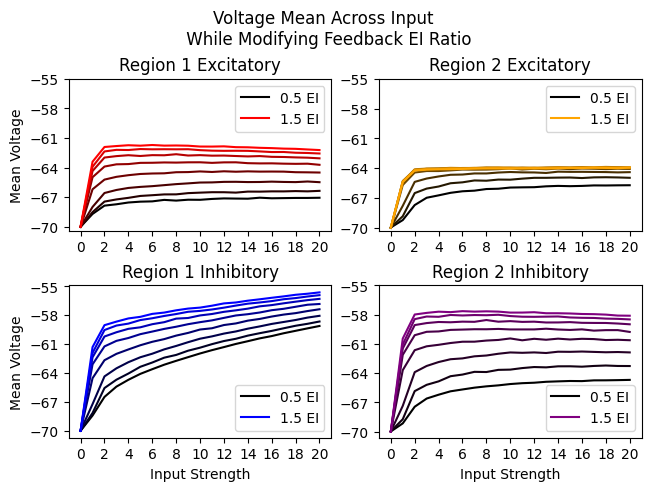

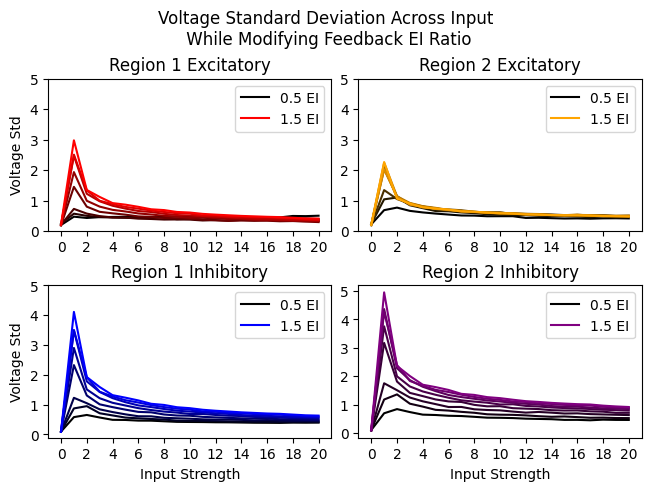

In [157]:
def colorRange(baseColor,toColor,number):
    baseColorRGB = colour.Color(baseColor).rgb
    toColorRGB = colour.Color(toColor).rgb
    colors = [baseColorRGB, toColorRGB]
    cm = LinearSegmentedColormap.from_list("Custom", colors, N=number) 
    return cm

def plotMeanInputAcrossEI(meanFrame,ax,baseColor='red',title='Average Response Across EI Ratio',
                      xTicks="implied",yTicks="implied",showXLabel=True,showYLabel=True,yLabel='Voltage'):
    colorMap = colorRange('black',baseColor,len(meanFrame.index))
    colors = [colorMap(i) for i in range(len(meanFrame.index))]
    frame = meanFrame
    for i in range(len(frame)):
        if i == 0:
            frame.iloc[i,:].plot(ax=ax,c=colors[i],label=f'{meanFrame.index[i]} EI')
        elif i == len(meanFrame.index)-1:
            frame.iloc[i,:].plot(ax=ax,c=colors[i],label=f'{meanFrame.index[i]} EI')
        else:
            frame.iloc[i,:].plot(ax=ax,c=colors[i],label='_nolegend_')
    ax.legend()
    ax.set_title(title)
    if showYLabel:
        ax.set_ylabel(yLabel)
    if showXLabel:
        ax.set_xlabel('Input Strength')
    if not (xTicks == "implied"):
        ax.set_xticks(xTicks)
    if not (yTicks == "implied"):
        ax.set_yticks(yTicks)
colorMapping = {'r1E':'red','r1I':'blue','r2E':'orange','r2I':'purple'}
#average plot
fig,axs = plt.subplots(2,2,layout='constrained')
plt.suptitle('Voltage Mean Across Input \n While Modifying Feedback EI Ratio')
plotYTicks = np.linspace(-70,-55,6)
plotXTicks = np.linspace(0,20,11)
line1=plotMeanInputAcrossEI(r1EDFMean,axs[0,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1E'],showXLabel=False,title='Region 1 Excitatory',yLabel='Mean Voltage')
line2=plotMeanInputAcrossEI(r1IDFMean,axs[1,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1I'],title='Region 1 Inhibitory',yLabel='Mean Voltage')
line3=plotMeanInputAcrossEI(r2EDFMean,axs[0,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2E'],showXLabel=False,showYLabel=False,title='Region 2 Excitatory')
line4=plotMeanInputAcrossEI(r2IDFMean,axs[1,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2I'],showYLabel=False,title='Region 2 Inhibitory')
fig.legend([line1,line2,line3,line4], loc='lower right', bbox_to_anchor=(1,-0.1), ncol=4, bbox_transform=fig.transFigure)
plt.savefig('./twoRegion/figs/EIRatioVoltageMean.png')
#std plot
fig,axs = plt.subplots(2,2,layout='constrained')
#fig.tight_layout(pad=1.5)
#plt.subplots_adjust(left=.125, bottom=.1, right=.9, top=2, wspace=.2, hspace=.2)
plt.suptitle('Voltage Standard Deviation Across Input\n While Modifying Feedback EI Ratio')
plotYTicks = np.linspace(0,5,6)
plotXTicks = np.linspace(0,20,11)
plotMeanInputAcrossEI(r1EDFStd,axs[0,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1E'],showXLabel=False,title='Region 1 Excitatory',yLabel='Voltage Std')
plotMeanInputAcrossEI(r1IDFStd,axs[1,0],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r1I'],title='Region 1 Inhibitory',yLabel='Voltage Std')
plotMeanInputAcrossEI(r2EDFStd,axs[0,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2E'],showXLabel=False,showYLabel=False,title='Region 2 Excitatory')
plotMeanInputAcrossEI(r2IDFStd,axs[1,1],yTicks=plotYTicks,xTicks=plotXTicks,baseColor=colorMapping['r2I'],showYLabel=False,title='Region 2 Inhibitory')
plt.savefig('./twoRegion/figs/EIRatioVoltageStd.png')